In [3]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

import mmint_tools.mmint_tf_tools.transformations as tr

from bubble_utils.bubble_tools.bubble_img_tools import process_bubble_img, unprocess_bubble_img, process_bubble_img_coordinates, unprocess_bubble_img_coordinates
from bubble_utils.bubble_shear_estimation.optical_flow.optical_flow import dense_optical_flow
from bubble_utils.bubble_shear_estimation.dot_detection.dot_detection import dot_detection
from mmint_camera_utils.camera_utils.camera_utils import project_depth_image

In [4]:
wrench_columns = ['wrench.force.x', 'wrench.force.y', 'wrench.force.z', 'wrench.torque.x', 'wrench.torque.y', 'wrench.torque.z']
tf_columns = ['x', 'y', 'z', 'qx', 'qy', 'qz', 'qw']

def _load_wrench(scene, fc):
    wrench_path = os.path.join(data_path, scene, 'wrenches', scene, 'wrenches', '{}_wrench_{:06d}.csv'.format(scene, fc))
    wrench_df = pd.read_csv(wrench_path)
    return wrench_df

def load_wrench(scene, fc, frame_id='med_base'):
    wrench_df = _load_wrench(scene, fc)
    wrench_in_frame = wrench_df[wrench_df['header.frame_id']==frame_id]
    wrench = wrench_in_frame[wrench_columns]
    return wrench.values

def _load_tf(scene, fc):
    tf_path = os.path.join(data_path, scene, 'tfs', 'recorded_tfs_{:06d}.csv'.format(fc))
    tf_df = pd.read_csv(tf_path)
    return tf_df

def load_tf(scene, fc, frame_id='grasp_frame', ref_id='med_base'):
    tf_df = _load_tf(scene, fc)
    tf_df_frame = tf_df[tf_df['parent_frame'] == ref_id]
    tf_df_frame = tf_df_frame[tf_df_frame['child_frame'] == frame_id]
    tf_i = tf_df_frame[tf_columns]
    return tf_i.values

def add_wrenches_and_tfs(df):
    df_out = df.copy()
    wrenches = []
    tfs = []
    for i, row_i in df_out.iterrows():
        wrench_i = load_wrench(row_i['Scene'], row_i['FileCode'])
        tf_i = load_tf(row_i['Scene'], row_i['FileCode'])
        wrenches.append(wrench_i)
        tfs.append(tf_i)
    wrenches = np.concatenate(wrenches, axis=0)
    tfs = np.concatenate(tfs, axis=0)
    wrenches_df = pd.DataFrame(wrenches, columns=wrench_columns)
    tfs_df = pd.DataFrame(tfs, columns=tf_columns)
    df_out = pd.concat([df_out, wrenches_df, tfs_df], axis=1)
    return df_out

def _load_img(file_dir, file_name, extension=None):
    # Load an image as a np.ndarray. The image can be saved as .png or .npy
    if extension is None:
        # find what is the file extension (.png, .npy, ...)
        all_files_in_file_dir = [f for f in os.listdir(file_dir) if os.path.isfile(os.path.join(file_dir, f))]
        our_files_in_file_dir = [f for f in all_files_in_file_dir if file_name in f]
        if len(our_files_in_file_dir) < 1:
            print('File with name {} in dir {} not found'.format(file_name, file_dir))
            raise ValueError('File with name {} in dir {} not found'.format(file_name, file_dir))
        else:
            our_file = our_files_in_file_dir[0]
    else:
        our_file = '{}.{}'.format(file_name, extension)
    path_to_file = os.path.join(file_dir, our_file)
    # read files on dir
    if '.png' in our_file:
        img = Image.open(path_to_file)  # TODO: Test this
        img_array = np.array(img)
    elif '.npy' in our_file:
        img_array = np.load(path_to_file)
    else:
        img_array = None
    return img_array


def _load_bubble_color_image(scene, fc, camera_indx='right'):
    img_path = os.path.join(data_path, scene, 'pico_flexx_{}'.format(camera_indx), 'color_data', '{}_color_{:06d}.png'.format(scene, fc))
    im = Image.open(img_path)
    im_ar = np.asarray(im)
    im_ar_uint8 = ((im_ar/np.max(im_ar))*255).astype('uint8')
    return im_ar_uint8

def _load_depth_img(fc, scene_name, camera_name):
    # depth can be saved as .png or .npy
    depth_dir = os.path.join(data_path, scene_name, 'pico_flexx_{}'.format(camera_name), 'depth_data')
    file_name = '{}_depth_{:06}'.format(scene_name, fc)
    depth_array = _load_img(depth_dir, file_name)
    depth_array_meters = depth_array
    return depth_array_meters

def _load_camera_info_depth(scene_name, camera_name, fc=None):
    camera_info_dir = os.path.join(data_path, scene_name, 'pico_flexx_{}'.format(camera_name), 'camera_info')
    fc_extension = ''
    if fc is not None:
        fc_extension = '_{:06}'.format(fc)
    file_name = '{}_camera_info_depth{}.npy'.format(scene_name, fc_extension)
    camera_info = np.load(os.path.join(camera_info_dir, file_name), allow_pickle=True).item()
    return camera_info


def _load_scene_img(scene, fc):
    img_path = os.path.join(data_path, scene, 'camera_1', 'color_data', '{}_color_{:06d}.png'.format(scene, fc))
    im = Image.open(img_path)
    im_ar = np.asarray(im)
    return im_ar 


In [5]:
def _compute_flow_seq(def_img_seq, ref_img, camera_name):
    flow_seq = []
    img_base = ref_img
    flow_acc = None
    for img_i in def_img_seq:
        flow_i = dense_optical_flow(img_base, img_i)
        if flow_acc is None:
            flow_acc = flow_i.copy()
        else:
            flow_acc = flow_acc + flow_i
        flow_seq.append(flow_acc)
        img_base = img_i
    
    return flow_seq
    
def compute_flow_seq(seq_fc, reference_fc, scene_name, camera_name):
    ref_img = _load_bubble_color_image(scene_name, reference_fc, camera_name)
    def_img_seq = [_load_bubble_color_image(scene_name, fc_i, camera_name) for fc_i in seq_fc]
    # process the images:
    ref_img = process_bubble_img(np.expand_dims(ref_img, axis=-1)).squeeze()
    def_img_seq = [process_bubble_img(np.expand_dims(img_i, axis=-1)).squeeze() for img_i in def_img_seq]
    flow_seq = _compute_flow_seq(def_img_seq, ref_img, camera_name)
    flow_seq = [unprocess_bubble_img(flow_i) for flow_i in flow_seq]
    return flow_seq

def compute_deformation(detected_points_ref, flow, depth_def, depth_ref, K):
    
    ref_coordinates = project_depth_image(depth_ref, K)
    def_coordinates = project_depth_image(depth_def, K)
    flow_i = flow[detected_points_ref[:,0], detected_points_ref[:,1]]
    detected_points_def = np.round(detected_points_ref + flow_i).astype(np.int64)
    # TODO: Filter points out of the image.
    good_indxs = np.where(np.all(detected_points_def > np.array([0.,0.]), axis=1) & 
                          np.all(detected_points_def< depth_ref.shape, axis=1) )
    detected_points_ref = detected_points_ref[good_indxs]
    detected_points_def = detected_points_def[good_indxs]
    ref_points = ref_coordinates[detected_points_ref[:,0], detected_points_ref[:,1]]
    
    def_points = def_coordinates[detected_points_def[:,0], detected_points_def[:,1]]
    
    displacements = def_points - ref_points
    displacement_norms = np.linalg.norm(displacements, axis=-1)
    num_points = len(detected_points_ref)
    k = int(np.floor(num_points*0.05)) # top 5%
    top_k_indxs = np.argpartition(displacement_norms, -k)[-k:]
    top_k_disp_norms = displacement_norms[top_k_indxs]
    deformation_score = np.mean(top_k_disp_norms)
    return deformation_score
    

def compute_deformations(seq_fc, reference_fc, scene_name, camera_name):
    ref_img = _load_bubble_color_image(scene_name, reference_fc, camera_name)
    ref_depth = _load_depth_img(reference_fc, scene_name, camera_name).squeeze()
    detected_points_ref_process_coords, _ = dot_detection(process_bubble_img(np.expand_dims(ref_img, axis=-1)))
    detected_points_ref = np.stack(unprocess_bubble_img_coordinates(detected_points_ref_process_coords[...,0], detected_points_ref_process_coords[...,1]),axis=-1)
    flow_seq = compute_flow_seq(seq_fc, reference_fc, scene_name, camera_name)
    depth_seq = [_load_depth_img(fc_i, scene_name, camera_name).squeeze() for fc_i in seq_fc]
    camera_K = _load_camera_info_depth(scene_name, camera_name)['K']
    deformations = [compute_deformation(detected_points_ref, flow_i, depth_seq[i], ref_depth, camera_K) for i, flow_i in enumerate(flow_seq)]
    return deformations
    
    

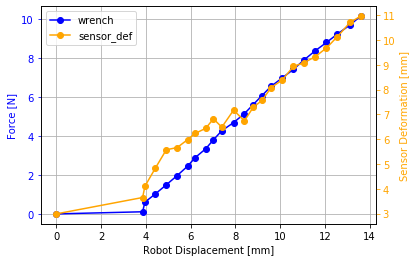

In [20]:
fig,ax = plt.subplots()
p1, = ax.plot(poses*1000, wrenches, label='wrench', color='blue', marker='o')
p11, = ax.plot(poses*)
ax.set_ylabel('Force [N]')
ax.set_xlabel('Robot Displacement [mm]')
ax_2 = ax.twinx()
p2, = ax_2.plot(poses*1000, 0.5*(left_defs+right_defs)*1000, label='sensor_def', marker='o', color='orange')
# ax_2.plot(poses, right_defs*1000, label='right_def', marker='o')
ax_2.set_ylabel('Sensor Deformation [mm]')
ax.yaxis.label.set_color(p1.get_color())
ax_2.yaxis.label.set_color(p2.get_color())
ax.tick_params(axis='y', colors=p1.get_color())
ax_2.tick_params(axis='y', colors=p2.get_color())

lns = ax.get_lines() + ax_2.get_lines()
labs = [l.get_label() for l in lns]
ax.legend(lns, labs)
ax.grid()

In [7]:
seq_fc = [i+32 for i in range(7,30)]
reference_fc = 5+32
scene = 'bubbles'

wrenches = np.array([load_wrench(scene, fc_i)[0,2] for fc_i in seq_fc])
poses = np.array([load_tf(scene, fc_i)[0,2] for fc_i in seq_fc])

poses = np.abs(poses - poses[0])
wrenches = wrenches - wrenches[0]

left_defs = np.array(compute_deformations(seq_fc, reference_fc, scene, 'left'))
right_defs = np.array(compute_deformations(seq_fc, reference_fc, scene, 'left'))
sensor_defs = 0.5*(left_defs+right_defs)
sensor_defs = sensor_defs - sensor_defs[0]
fig,ax = plt.subplots()
ax.plot(poses, wrenches, label='wrench', color='g', marker='o')
ax.set_ylabel('Force [N]')
ax.set_xlabel('Robot Displacement [m]')
ax_2 = ax.twinx()
ax_2.plot(poses, sensor_defs*1000, label='sensor_def', marker='o', color='orange')
# ax_2.plot(poses, right_defs*1000, label='right_def', marker='o')
ax_2.set_ylabel('Sensor Deformation [mm]')

lns = ax.get_lines() + ax_2.get_lines()
labs = [l.get_label() for l in lns]
ax.legend(lns, labs)
ax.grid()

NameError: name 'data_path' is not defined

In [ ]:
sensor_defs_bubbles = sensor_defs
wrenches_bubbles = wrenches
poses_bubbles = poses

In [8]:
plt.plot(0.5*(left_defs+right_defs)*1000, wrenches, marker='o')
plt.grid()

NameError: name 'left_defs' is not defined

In [9]:
plt.plot(wrenches, 0.5*(left_defs+right_defs)*1000, marker='o')
plt.grid()

NameError: name 'wrenches' is not defined

In [ ]:
ax_2.get_lines()

In [10]:
x = np.random.uniform(0,1, (8,2))
x


array([[0.75234986, 0.07974262],
       [0.86044883, 0.5570569 ],
       [0.77937154, 0.75818119],
       [0.90006379, 0.65242977],
       [0.84996902, 0.04360363],
       [0.732805  , 0.5636684 ],
       [0.10053767, 0.50366894],
       [0.59554069, 0.09637858]])

In [52]:
x[np.where(np.all(x > np.array([0.2,0.2]), axis=1) & np.all(x< np.array([0.9 , 0.8]), axis=1) )]

array([[0.5159664 , 0.62835707],
       [0.44072103, 0.35179258],
       [0.54632926, 0.46332913]])

# TOP DOWN CONTACT EVALUATION

In [36]:
data_dir = '/home/mmint/Desktop'
data_name = 'bubble_vs_gelsight_top_down_calibration_data'
data_path = os.path.join(data_dir, data_name)

dl_path = os.path.join(data_path, '{}_DataLegend.csv'.format(data_name))
dl = pd.read_csv(dl_path)
dl

,Time,Scene,SensorName,Sequence,SequenceIndx,FileCode,ReferenceFC,JointState
0,1.650655e+09,bubbles,bubbles,0,0,2,1,"(0.5563032260338174, 0.8844302852565187, -0.92..."
1,1.650655e+09,bubbles,bubbles,0,1,3,1,"(0.5566574796572517, 0.893417794862395, -0.923..."
2,1.650655e+09,bubbles,bubbles,0,2,4,1,"(0.5569921991193653, 0.9011874074984944, -0.92..."
3,1.650655e+09,bubbles,bubbles,0,3,5,1,"(0.5573912737797385, 0.9112343824657964, -0.92..."
4,1.650655e+09,bubbles,bubbles,0,4,6,1,"(0.5576048925899548, 0.9177774696606291, -0.92..."
...,...,...,...,...,...,...,...,...
229,1.651537e+09,gelsight,gelsight,6,36,237,200,"(0.598356170779073, 1.117544731704539, -1.0094..."
230,1.651537e+09,gelsight,gelsight,6,37,238,200,"(0.6004637166101308, 1.120916852899886, -1.014..."
231,1.651537e+09,gelsight,gelsight,6,38,239,200,"(0.6025903172914633, 1.1242366029821163, -1.01..."
232,1.651537e+09,gelsight,gelsight,6,39,240,200,"(0.6047320181251518, 1.127476658058208, -1.024..."


In [7]:
dl[dl['Sequence']==1]

,Time,Scene,SensorName,Sequence,SequenceIndx,FileCode,ReferenceFC,JointState
29,1.650655e+09,bubbles,bubbles,1,0,32,31,"(0.556038075068439, 0.8852174091142141, -0.922..."
30,1.650655e+09,bubbles,bubbles,1,1,33,31,"(0.5564301988459831, 0.8938825430991115, -0.92..."
31,1.650655e+09,bubbles,bubbles,1,2,34,31,"(0.5567386728103868, 0.902217931046682, -0.923..."
32,1.650655e+09,bubbles,bubbles,1,3,35,31,"(0.5569646353526547, 0.9118868635528452, -0.92..."
33,1.650655e+09,bubbles,bubbles,1,4,36,31,"(0.5570816014286372, 0.9187681455966644, -0.92..."
34,1.650655e+09,bubbles,bubbles,1,5,37,31,"(0.557474504277526, 0.9277397160922298, -0.924..."
35,1.650655e+09,bubbles,bubbles,1,6,38,31,"(0.5577736304766223, 0.9364156957712654, -0.92..."
36,1.650655e+09,bubbles,bubbles,1,7,39,31,"(0.5586940789450466, 0.9385894543763224, -0.92..."
37,1.650655e+09,bubbles,bubbles,1,8,40,31,"(0.5608512393598339, 0.9417092477584716, -0.93..."
38,1.650655e+09,bubbles,bubbles,1,9,41,31,"(0.5629952171936977, 0.9448607992607733, -0.93..."


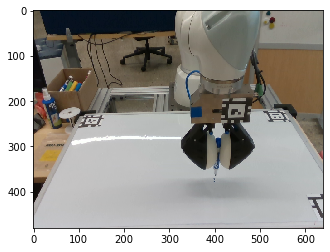

In [520]:
img = _load_scene_img(dl['Scene'].iloc[0], dl['FileCode'].iloc[0])
plt.imshow(img)

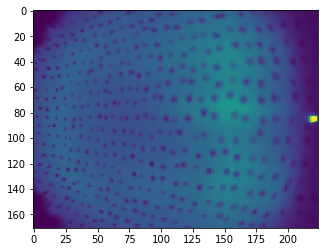

In [521]:
img = _load_bubble_color_image(dl['Scene'].iloc[0], dl['FileCode'].iloc[0])
plt.imshow(img)

In [8]:
df_out = add_wrenches_and_tfs(dl)
df_out['Sensor_Seq'] = df_out['SensorName'] + '_' + df_out['Sequence'].astype(str)

In [9]:
# SIDEWAYS:
x_key = 'z'
y_key = 'wrench.force.z'

x_range_ss = [0.12,0.22]
x_range = [0, 0.12]

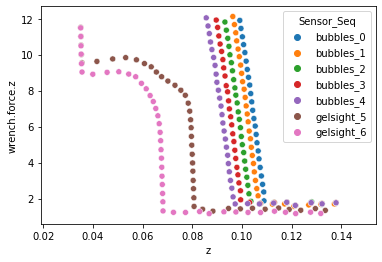

In [10]:
sns.scatterplot(x=x_key, y=y_key, data=df_out, hue='Sensor_Seq')

In [469]:
steady_data = df_out[(df_out[x_key] < x_range_ss[1]) & (df_out[x_key] > x_range_ss[0]) ]

unique_sensor_seq = np.unique(df_out['Sensor_Seq'])
means = {}
for sensor_seq_i in unique_sensor_seq:
    sensor_ss = steady_data[steady_data.Sensor_Seq == sensor_seq_i] 
    means[sensor_seq_i] = np.mean(sensor_ss[y_key])

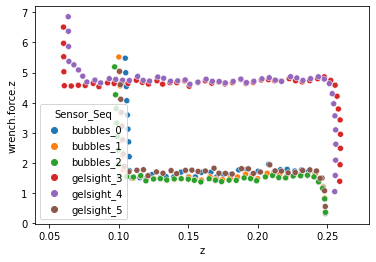

In [470]:
ax = sns.scatterplot(x=x_key, y=y_key, data=df_out, hue='Sensor_Seq')

In [471]:
df_out['steady_value'] = df_out['Sensor_Seq'].map(means)
df_out['{}_norm'.format(y_key)] = -df_out['steady_value'] + df_out[y_key]

# df_norm = df_out[(df_out[x_key] < x_range[1]) & (df_out[x_key] > x_range[0]) ]


x_elbow_map_pre = {'bubbles': 0.11, 'gelsight':0.065}
df_out['x_elbow'] = df_out['SensorName'].map(x_elbow_map_pre)
df_out['{}_norm'.format(x_key)] = -df_out[x_key] + df_out['x_elbow']



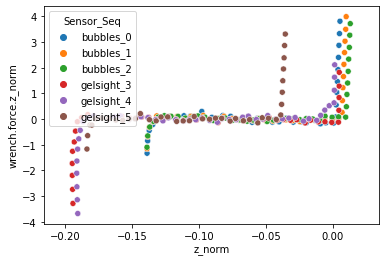

In [472]:
ax = sns.scatterplot(x='{}_norm'.format(x_key), y='{}_norm'.format(y_key), data=df_out, hue='Sensor_Seq')

In [473]:
# # ESTIMATE ELBOWs:
unique_sensor_seq = np.unique(df_out['Sensor_Seq'])
x_elbow_map = {}
for sensor_seq_i in unique_sensor_seq:
    sensor_seq_df = df_out[df_out.Sensor_Seq == sensor_seq_i]
    sensor_seq_df = sensor_seq_df[sensor_seq_df['{}_norm'.format(x_key)] > -0.03]
    sensor_seq_df = sensor_seq_df[sensor_seq_df['{}_norm'.format(y_key)] > 0.58]
    sensor_seq_data = sensor_seq_df['{}_norm'.format(y_key)]
    if len(sensor_seq_data) > 0:
        elbow_value_i = sensor_seq_df['{}_norm'.format(x_key)].iloc[np.argmin(sensor_seq_data)]
    #     import pdb; pdb.set_trace()
        x_elbow_map[sensor_seq_i] = elbow_value_i
    else:
        x_elbow_map[sensor_seq_i] = 0

    
df_out['x_elbow'] = df_out['Sensor_Seq'].map(x_elbow_map)
df_out['{}_norm'.format(x_key)] = df_out['{}_norm'.format(x_key)] - df_out['x_elbow']


df_norm_filtered = df_out[df_out['{}_norm'.format(x_key)] > 0]

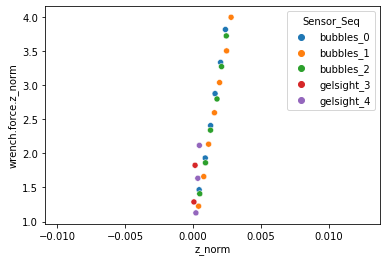

In [474]:
ax = sns.scatterplot(x='{}_norm'.format(x_key), y='{}_norm'.format(y_key), data=df_norm_filtered, hue='Sensor_Seq')

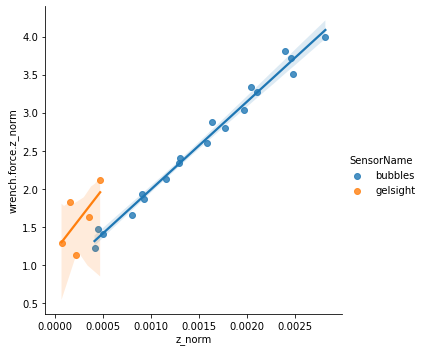

In [475]:
ax = sns.lmplot(x='{}_norm'.format(x_key), y='{}_norm'.format(y_key), data=df_norm_filtered, hue='SensorName')

In [478]:
def regression_plots(df, keys, x_range, label_map=None):
    regressions = {}
    xs = np.linspace(0, x_range, 100)
    palette = sns.color_palette('tab10')
    fig, ax = plt.subplots()
    for i, key in enumerate(keys):
        raw_data = df[df['Sensor_Seq'] == key]
        force_data = np.stack([raw_data['{}_norm'.format(x_key)].values, raw_data['{}_norm'.format(y_key)].values], axis=0) # x, y
        reg_i = LinearRegression().fit(force_data[0:1].T, force_data[1:2].T)
        regressions[key] = reg_i
        # plot
        color_i = palette[i]
        ys = reg_i.predict(xs[:,None])
        label_i = key
        if label_map is not None:
            label_i = label_map[key]
        ax.plot(xs,ys-reg_i.intercept_[0], color=color_i, label=label_i)
        ax.scatter(force_data[0], force_data[1]-reg_i.intercept_[0], marker='o', color=color_i)
        
        plt.legend()
    return ax, regressions

gelsight_4 [[3867.3866968]] [0.27450255]
bubbles_1 [[1131.96325974]] [0.78046427]


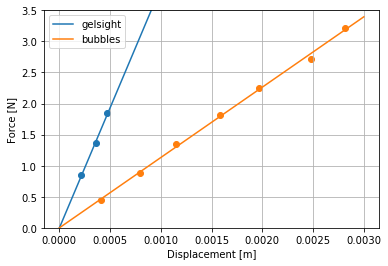

In [479]:
ax, regs = regression_plots(df_norm_filtered, ['gelsight_4', 'bubbles_1'], 0.003, label_map={'gelsight_4':'gelsight', 'bubbles_1':'bubbles'})
ax.set_ylim([0,3.5])
ax.set_xlabel('Displacement [m]')
ax.set_ylabel('Force [N]')
ax.grid()
for k, reg_i in regs.items():
    print(k, reg_i.coef_, reg_i.intercept_)

In [483]:
# save figure
fig = ax.figure
fig.savefig(os.path.join(data_path,'bubbles_vs_gelsight.svg'))

In [5]:
seq_fc = [i for i in range(7,31)]
reference_fc = 5
scene = 'bubbles'

wrenches = np.array([load_wrench(scene, fc_i)[0,2] for fc_i in seq_fc])
poses = np.array([load_tf(scene, fc_i)[0,2] for fc_i in seq_fc])

poses = np.abs(poses - poses[0])
wrenches = wrenches - wrenches[0]

left_defs = np.array(compute_deformations(seq_fc, reference_fc, scene, 'left'))
right_defs = np.array(compute_deformations(seq_fc, reference_fc, scene, 'left'))
sensor_defs = 0.5*(left_defs+right_defs)
sensor_defs = sensor_defs - sensor_defs[0]

In [37]:
seq_fc = [i+32 for i in range(7,30)]
reference_fc = 5+32
scene = 'bubbles'

wrenches = np.array([load_wrench(scene, fc_i)[0,2] for fc_i in seq_fc])
poses = np.array([load_tf(scene, fc_i)[0,2] for fc_i in seq_fc])

left_defs = np.array(compute_deformations(seq_fc, reference_fc, scene, 'left'))
right_defs = np.array(compute_deformations(seq_fc, reference_fc, scene, 'left'))
sensor_defs = 0.5*(left_defs+right_defs)


sensor_defs = sensor_defs - sensor_defs[0]
poses = np.abs(poses - poses[0])
wrenches = wrenches - wrenches[0]


sensor_defs_bubbles = sensor_defs
wrenches_bubbles = wrenches
poses_bubbles = poses

In [50]:
seq_fc = [i for i in range(170,199)]
reference_fc = 169
scene = 'gelsight'

wrenches = np.array([load_wrench(scene, fc_i)[0,2] for fc_i in seq_fc])
poses = np.array([load_tf(scene, fc_i)[0,2] for fc_i in seq_fc])

poses = np.abs(poses - poses[0])
wrenches = wrenches - wrenches[0]

sensor_defs = 0.0011*np.arange(len(poses))/(len(poses)-1)
# sensor_defs = np.zeros_like(poses)
# import pdb; pdb.set_trace()


sensor_defs_gelsight = sensor_defs
wrenches_gelsight = wrenches
poses_gelsight = poses

In [51]:
sensor_defs_gelsight

array([0.00000000e+00, 3.92857143e-05, 7.85714286e-05, 1.17857143e-04,
       1.57142857e-04, 1.96428571e-04, 2.35714286e-04, 2.75000000e-04,
       3.14285714e-04, 3.53571429e-04, 3.92857143e-04, 4.32142857e-04,
       4.71428571e-04, 5.10714286e-04, 5.50000000e-04, 5.89285714e-04,
       6.28571429e-04, 6.67857143e-04, 7.07142857e-04, 7.46428571e-04,
       7.85714286e-04, 8.25000000e-04, 8.64285714e-04, 9.03571429e-04,
       9.42857143e-04, 9.82142857e-04, 1.02142857e-03, 1.06071429e-03,
       1.10000000e-03])

In [52]:
sensor_defs_bubbles

array([0.        , 0.00050847, 0.00153385, 0.00151021, 0.00194528,
       0.00235139, 0.00232306, 0.00257168, 0.00307042, 0.00302223,
       0.00313964, 0.00307636, 0.00373492, 0.00364323, 0.00415227,
       0.00451147, 0.0048549 , 0.00532898, 0.005744  , 0.00610862,
       0.00657012, 0.00703234, 0.00724368])

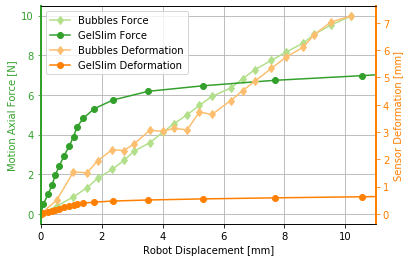

In [53]:
palette = sns.color_palette("Paired")



fig,ax = plt.subplots()
p1, = ax.plot(poses_bubbles*1000, wrenches_bubbles, label='Bubbles Force', color=palette[2], marker='d')
p2, = ax.plot(poses_gelsight*1000, wrenches_gelsight, label='GelSlim Force', color=palette[3], marker='o')
ax.set_ylabel('Motion Axial Force [N]')
ax.set_xlabel('Robot Displacement [mm]')
ax_2 = ax.twinx()
p3, = ax_2.plot(poses_bubbles*1000, sensor_defs_bubbles*1000, label='Bubbles Deformation', marker='d', color=palette[6])
p4, = ax_2.plot(poses_gelsight*1000, sensor_defs_gelsight*1000, label='GelSlim Deformation', marker='o', color=palette[7])

ax_2.set_ylabel('Sensor Deformation [mm]')

ax.set_xlim(0,11)

ax.yaxis.label.set_color(p2.get_color())
ax_2.yaxis.label.set_color(p4.get_color())
ax.tick_params(axis='y', colors=p2.get_color())
ax_2.tick_params(axis='y', colors=p4.get_color())
ax_2.spines['left'].set_color(p2.get_color())
ax_2.spines['right'].set_color(p4.get_color())
ax_2.spines['left'].set_linewidth(2)
ax_2.spines['right'].set_linewidth(2)

lns = ax.get_lines() + ax_2.get_lines()
labs = [l.get_label() for l in lns]
ax.legend(lns, labs)
ax.grid()

# save figure
fig = ax.figure
fig.savefig(os.path.join(data_path,'bubbles_vs_gelsight.svg'))

In [25]:
data_path

'/home/mmint/Desktop/bubble_vs_gelsight_top_down_calibration_data'

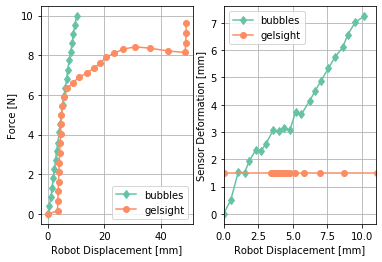

In [25]:
palette = sns.color_palette("Set2")



fig,ax = plt.subplots(1,2)
ax_1 = ax[0]
ax_2 = ax[1]
p1, = ax_1.plot(poses_bubbles*1000, wrenches_bubbles, label='bubbles', color=palette[0], marker='d')
p2, = ax_1.plot(poses_gelsight*1000, wrenches_gelsight, label='gelsight', color=palette[1], marker='o')
ax_1.set_ylabel('Force [N]')
ax_1.set_xlabel('Robot Displacement [mm]')
ax_2.set_xlabel('Robot Displacement [mm]')
# ax_2 = ax.twinx()
p3, = ax_2.plot(poses_bubbles*1000, sensor_defs_bubbles*1000, label='bubbles', marker='d', color=palette[0])
p4, = ax_2.plot(poses_gelsight*1000, sensor_defs_gelsight*1000, label='gelsight', marker='o', color=palette[1])

ax_2.set_ylabel('Sensor Deformation [mm]')
ax_2.set_xlim(0,11)

lns = ax_1.get_lines() + ax_2.get_lines()
labs = [l.get_label() for l in lns]
ax_1.legend()# (lns, labs)
ax_2.legend()
ax_1.grid()
ax_2.grid()


# SIDEWAYS CONTACT EVALUATION:

In [26]:
data_dir = '/home/mmint/Desktop'
data_name = 'bubble_vs_gelsight_sideways_calibration_data'
data_path = os.path.join(data_dir, data_name)

dl_path = os.path.join(data_path, '{}_DataLegend.csv'.format(data_name))
dl = pd.read_csv(dl_path)
dl

,Time,Scene,SensorName,Sequence,SequenceIndx,FileCode,ReferenceFC,JointState
0,1.650999e+09,bubbles,bubbles,0,0,2,1,"(0.29997929072726154, 0.6969443370542214, -0.7..."
1,1.650999e+09,bubbles,bubbles,0,1,3,1,"(0.30956151745784727, 0.695106376415673, -0.71..."
2,1.650999e+09,bubbles,bubbles,0,2,4,1,"(0.318825203492153, 0.6933950291605472, -0.710..."
3,1.650999e+09,bubbles,bubbles,0,3,5,1,"(0.3288813463467666, 0.6915549711816532, -0.71..."
4,1.650999e+09,bubbles,bubbles,0,4,6,1,"(0.3380559896096264, 0.6901775643172963, -0.71..."
...,...,...,...,...,...,...,...,...
86,1.651538e+09,gelsight,gelsight,6,5,94,88,"(0.12925364061168, 0.6846128093264474, -0.3782..."
87,1.651538e+09,gelsight,gelsight,6,6,95,88,"(0.13607062723476657, 0.6838053722360865, -0.3..."
88,1.651538e+09,gelsight,gelsight,6,7,96,88,"(0.1390847796552004, 0.6834176225808972, -0.37..."
89,1.651538e+09,gelsight,gelsight,6,8,97,88,"(0.14371860013039575, 0.6827704145698511, -0.3..."


In [486]:
df_out = add_wrenches_and_tfs(dl)
df_out['Sensor_Seq'] = df_out['SensorName'] + '_' + df_out['Sequence'].astype(str)
df_out

,Unnamed: 0,Time,Scene,SensorName,Sequence,SequenceIndx,FileCode,JointState,wrench.force.x,wrench.force.y,...,wrench.torque.y,wrench.torque.z,x,y,z,qx,qy,qz,qw,Sensor_Seq
0,0,1.650387e+09,gelsight,bubbles,0,0,1,"(-0.43475813847793715, 0.7157415938574748, -0....",0.679899,-0.942702,...,0.290164,0.044782,0.549554,-0.291057,0.150289,-0.707164,0.707048,0.001456,0.000798,bubbles_0
1,1,1.650387e+09,gelsight,bubbles,0,1,2,"(-0.4210751496232172, 0.706530518591809, -0.08...",0.796776,-1.136427,...,0.264012,0.002117,0.549602,-0.281348,0.150259,-0.707111,0.707100,0.001646,0.001023,bubbles_0
2,2,1.650387e+09,gelsight,bubbles,0,2,3,"(-0.40590006493741626, 0.6968202404355799, -0....",0.616799,-1.038514,...,0.221504,0.015620,0.549591,-0.271126,0.150258,-0.707125,0.707085,0.001623,0.001102,bubbles_0
3,3,1.650387e+09,gelsight,bubbles,0,3,4,"(-0.3904033835928982, 0.6876256434778806, -0.0...",0.706146,-0.969429,...,0.241389,-0.007964,0.549595,-0.260938,0.150262,-0.707098,0.707113,0.001655,0.001088,bubbles_0
4,4,1.650387e+09,gelsight,bubbles,0,4,5,"(-0.3754515650247541, 0.6791338613756944, -0.0...",0.849489,-1.057702,...,0.269867,0.001145,0.549607,-0.251092,0.150276,-0.707109,0.707102,0.001756,0.001120,bubbles_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,217,1.650390e+09,gelsight,gelsight,6,13,218,"(-0.048146503738030685, 0.630390003974953, -0....",2.417351,-1.257302,...,0.584721,0.215882,0.549657,-0.088886,0.121001,0.707191,-0.707020,-0.001916,-0.000350,gelsight_6
218,218,1.650390e+09,gelsight,gelsight,6,14,219,"(-0.021641772492455143, 0.6263002674229529, -0...",2.349683,0.040226,...,0.666500,0.013921,0.549623,-0.074209,0.121002,0.707076,-0.707135,-0.001922,-0.000308,gelsight_6
219,219,1.650390e+09,gelsight,gelsight,6,15,220,"(0.005682380146790066, 0.6232424324656677, -0....",3.038315,0.097946,...,0.791158,0.018574,0.549677,-0.059123,0.120986,0.707085,-0.707126,-0.002073,-0.000176,gelsight_6
220,220,1.650390e+09,gelsight,gelsight,6,16,221,"(0.0289447793160984, 0.6208860343173683, -0.15...",3.005981,-1.228559,...,0.738814,0.042937,0.549632,-0.047197,0.121007,0.707258,-0.706954,-0.001180,0.000800,gelsight_6


In [487]:
df_out[df_out.Sensor_Seq == 'bubbles_1']

,Unnamed: 0,Time,Scene,SensorName,Sequence,SequenceIndx,FileCode,JointState,wrench.force.x,wrench.force.y,...,wrench.torque.y,wrench.torque.z,x,y,z,qx,qy,qz,qw,Sensor_Seq
29,29,1.650388e+09,gelsight,bubbles,1,0,30,"(-0.40677491340664, 0.7156585431286003, -0.126...",-0.156045,-0.237119,...,0.116759,0.037654,0.549516,-0.289604,0.150344,-0.707154,0.707058,0.001282,0.001019,bubbles_1
30,30,1.650388e+09,gelsight,bubbles,1,1,31,"(-0.39388372229226915, 0.7073692944869695, -0....",0.286547,-0.867051,...,0.165223,0.066865,0.549572,-0.280737,0.150360,-0.707185,0.707026,0.001525,0.001136,bubbles_1
31,31,1.650388e+09,gelsight,bubbles,1,2,32,"(-0.37747570058911134, 0.697327233057844, -0.1...",0.188751,-0.545337,...,0.166916,0.032063,0.549546,-0.270143,0.150335,-0.707146,0.707066,0.001433,0.001053,bubbles_1
32,32,1.650388e+09,gelsight,bubbles,1,3,33,"(-0.3622199020612211, 0.6885836624491989, -0.1...",0.411184,-0.619078,...,0.208487,0.009921,0.549566,-0.260287,0.150323,-0.707117,0.707094,0.001516,0.001022,bubbles_1
33,33,1.650388e+09,gelsight,bubbles,1,4,34,"(-0.34689944879293855, 0.6799903140746022, -0....",0.418932,-0.677048,...,0.212194,0.005826,0.549565,-0.250413,0.150350,-0.707114,0.707097,0.001581,0.001082,bubbles_1
34,34,1.650388e+09,gelsight,bubbles,1,5,35,"(-0.3308821726026311, 0.6714917009718897, -0.1...",0.349178,-0.634305,...,0.191701,0.004307,0.549559,-0.240306,0.150322,-0.707112,0.707099,0.001553,0.001103,bubbles_1
35,35,1.650388e+09,gelsight,bubbles,1,6,36,"(-0.31485896436544536, 0.6634972042979173, -0....",0.448172,-0.629966,...,0.195458,0.007828,0.549578,-0.230314,0.150319,-0.707120,0.707091,0.001566,0.001110,bubbles_1
36,36,1.650388e+09,gelsight,bubbles,1,7,37,"(-0.2989481080991151, 0.6560645880150239, -0.1...",0.643658,-0.742740,...,0.253033,0.010978,0.549578,-0.220524,0.150328,-0.707119,0.707092,0.001659,0.001057,bubbles_1
37,37,1.650388e+09,gelsight,bubbles,1,8,38,"(-0.2826465063199346, 0.6486705608528092, -0.1...",0.637049,-0.742870,...,0.248189,0.050916,0.549576,-0.210541,0.150321,-0.707167,0.707044,0.001660,0.001075,bubbles_1
38,38,1.650388e+09,gelsight,bubbles,1,9,39,"(-0.26644221635494664, 0.6417410423808709, -0....",0.704725,-0.817499,...,0.257456,0.070183,0.549587,-0.200682,0.150337,-0.707191,0.707020,0.001713,0.001097,bubbles_1


In [488]:
# SIDEWAYS:
x_key = 'y'
y_key = 'wrench.force.y'

x_range_ss = [-0.25,-0.08]
x_range = [-0.055, 0]

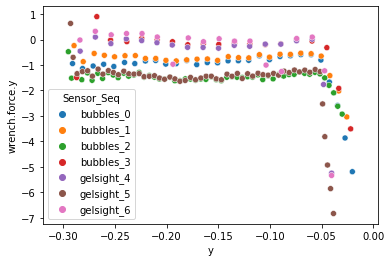

In [489]:
sns.scatterplot(x=x_key, y=y_key, data=df_out, hue='Sensor_Seq')

In [490]:
steady_data = df_out[(df_out[x_key] < x_range_ss[1]) & (df_out[x_key] > x_range_ss[0]) ]

unique_sensor_seq = np.unique(df_out['Sensor_Seq'])
means = {}
for sensor_seq_i in unique_sensor_seq:
    sensor_ss = steady_data[steady_data.Sensor_Seq == sensor_seq_i] 
    means[sensor_seq_i] = np.mean(sensor_ss[y_key])

In [491]:
df_out['steady_value'] = df_out['Sensor_Seq'].map(means)
df_out['{}_norm'.format(y_key)] = df_out['steady_value'] - df_out[y_key]

df_norm = df_out[(df_out[x_key] < x_range[1]) & (df_out[x_key] > x_range[0]) ]


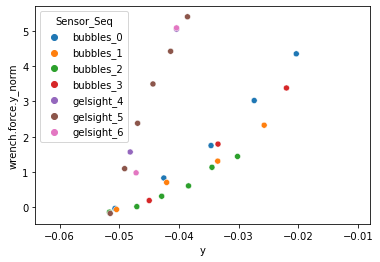

In [492]:
ax = sns.scatterplot(x=x_key, y='{}_norm'.format(y_key), data=df_norm, hue='Sensor_Seq')

(-0.08, 0.0)

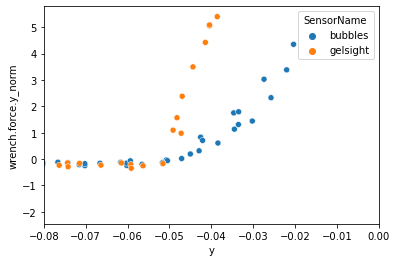

In [493]:
ax = sns.scatterplot(x=x_key, y='{}_norm'.format(y_key), data=df_out, hue='SensorName')
ax.set_xlim([-0.08, 0.])

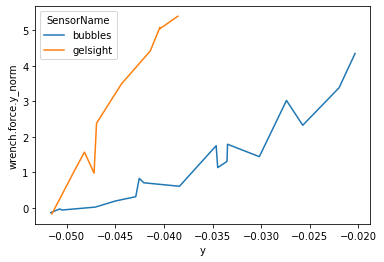

In [494]:
ax = sns.lineplot(x='y', y='{}_norm'.format(y_key), data=df_norm, hue='SensorName', ci='sd')

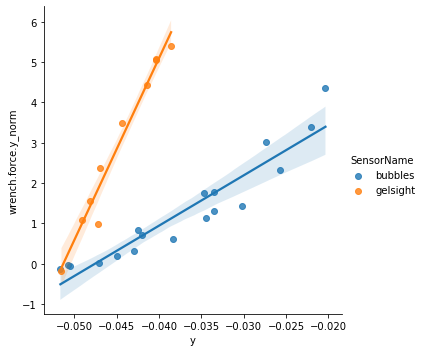

In [495]:
ax = sns.lmplot(x='y', y='{}_norm'.format(y_key), data=df_norm, hue='SensorName')

gelsight_5 [[427.33863516]] [0.06290518]
bubbles_2 [[76.72056767]] [-0.27191394]


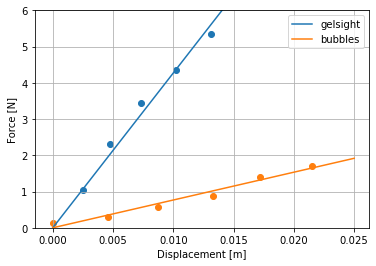

In [496]:
df_norm_f = df_norm.copy()
df_norm_f['{}_norm'.format(x_key)] = df_norm_f['{}'.format(x_key)] - np.min(df_norm_f['{}'.format(x_key)].values)
ax, regs = regression_plots(df_norm_f, ['gelsight_5', 'bubbles_2'], 0.025, {'gelsight_5': 'gelsight', 'bubbles_2':'bubbles'})
ax.set_ylim(0,6)
ax.set_xlabel('Displacement [m]')
ax.set_ylabel('Force [N]')
ax.grid()
for k, reg_i in regs.items():
    print(k, reg_i.coef_, reg_i.intercept_)

In [498]:
# save figure
fig = ax.figure
fig.savefig(os.path.join(data_path,'bubbles_vs_gelsight_sideways.svg'))

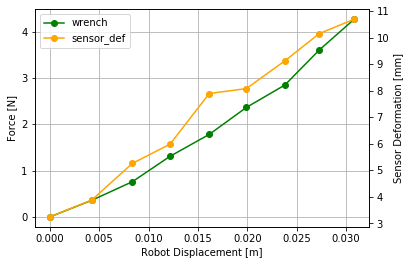

In [108]:
seq_fc = [i for i in range(7,16)]
reference_fc = 5
scene = 'bubbles'

wrenches = np.array([load_wrench(scene, fc_i)[0,1] for fc_i in seq_fc])
poses = np.array([load_tf(scene, fc_i)[0,1] for fc_i in seq_fc])

poses = np.abs(poses - poses[0])
wrenches = np.abs(wrenches - wrenches[0])

left_defs = np.array(compute_deformations(seq_fc, reference_fc, scene, 'left'))
right_defs = np.array(compute_deformations(seq_fc, reference_fc, scene, 'left'))
fig,ax = plt.subplots()
ax.plot(poses, wrenches, label='wrench', color='g', marker='o')
ax.set_ylabel('Force [N]')
ax.set_xlabel('Robot Displacement [m]')
ax_2 = ax.twinx()
ax_2.plot(poses, 0.5*(left_defs+right_defs)*1000, label='sensor_def', marker='o', color='orange')
# ax_2.plot(poses, right_defs*1000, label='right_def', marker='o')
ax_2.set_ylabel('Sensor Deformation [mm]')

lns = ax.get_lines() + ax_2.get_lines()
labs = [l.get_label() for l in lns]
ax.legend(lns, labs)
ax.grid()

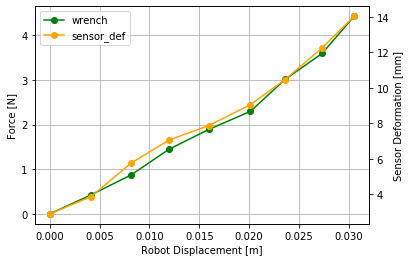

In [110]:
seq_fc = [i for i in range(23,32)]
reference_fc = 18
scene = 'bubbles'

wrenches = np.array([load_wrench(scene, fc_i)[0,1] for fc_i in seq_fc])
poses = np.array([load_tf(scene, fc_i)[0,1] for fc_i in seq_fc])

poses = np.abs(poses - poses[0])
wrenches = np.abs(wrenches - wrenches[0])

left_defs = np.array(compute_deformations(seq_fc, reference_fc, scene, 'left'))
right_defs = np.array(compute_deformations(seq_fc, reference_fc, scene, 'left'))
fig,ax = plt.subplots()
ax.plot(poses, wrenches, label='wrench', color='g', marker='o')
ax.set_ylabel('Force [N]')
ax.set_xlabel('Robot Displacement [m]')
ax_2 = ax.twinx()
ax_2.plot(poses, 0.5*(left_defs+right_defs)*1000, label='sensor_def', marker='o', color='orange')
# ax_2.plot(poses, right_defs*1000, label='right_def', marker='o')
ax_2.set_ylabel('Sensor Deformation [mm]')

lns = ax.get_lines() + ax_2.get_lines()
labs = [l.get_label() for l in lns]5050
ax.legend(lns, labs)
ax.grid()

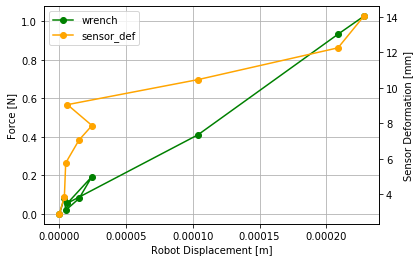

In [111]:
seq_fc = [i for i in range(23,32)]
reference_fc = 18
scene = 'bubbles'

wrenches = np.array([load_wrench(scene, fc_i)[0,2] for fc_i in seq_fc])
poses = np.array([load_tf(scene, fc_i)[0,2] for fc_i in seq_fc])

poses = np.abs(poses - poses[0])
wrenches = np.abs(wrenches - wrenches[0])

left_defs = np.array(compute_deformations(seq_fc, reference_fc, scene, 'left'))
right_defs = np.array(compute_deformations(seq_fc, reference_fc, scene, 'left'))
fig,ax = plt.subplots()
ax.plot(poses, wrenches, label='wrench', color='g', marker='o')
ax.set_ylabel('Force [N]')
ax.set_xlabel('Robot Displacement [m]')
ax_2 = ax.twinx()
ax_2.plot(poses, 0.5*(left_defs+right_defs)*1000, label='sensor_def', marker='o', color='orange')
# ax_2.plot(poses, right_defs*1000, label='right_def', marker='o')
ax_2.set_ylabel('Sensor Deformation [mm]')

lns = ax.get_lines() + ax_2.get_lines()
labs = [l.get_label() for l in lns]
ax.legend(lns, labs)
ax.grid()

In [30]:
seq_fc = [i for i in range(7,16)]
reference_fc = 5
scene = 'bubbles'

wrenches = np.array([load_wrench(scene, fc_i)[0,1] for fc_i in seq_fc])
poses = np.array([load_tf(scene, fc_i)[0,1] for fc_i in seq_fc])

left_defs = np.array(compute_deformations(seq_fc, reference_fc, scene, 'left'))
right_defs = np.array(compute_deformations(seq_fc, reference_fc, scene, 'left'))
sensor_defs = 0.5*(left_defs+right_defs)


sensor_defs = sensor_defs - sensor_defs[0]
poses = np.abs(poses - poses[0])
wrenches = np.abs(wrenches - wrenches[0])


sensor_defs_bubbles = sensor_defs
wrenches_bubbles = wrenches
poses_bubbles = poses

In [31]:
seq_fc = [i for i in range(72,77)]
reference_fc = 65
scene = 'gelsight'

wrenches = np.array([load_wrench(scene, fc_i)[0,1] for fc_i in seq_fc])
poses = np.array([load_tf(scene, fc_i)[0,1] for fc_i in seq_fc])

poses = np.abs(poses - poses[0])
wrenches = np.abs(wrenches - wrenches[0])

# sensor_defs = 0.0015*np.ones_like(poses)
sensor_defs = 0.0006*np.arange(len(poses))/(len(poses)-1)


sensor_defs_gelsight = sensor_defs
wrenches_gelsight = wrenches
poses_gelsight = poses

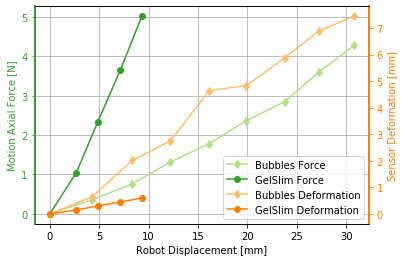

In [32]:
palette = sns.color_palette("Paired")



fig,ax = plt.subplots()
p1, = ax.plot(poses_bubbles*1000, wrenches_bubbles, label='Bubbles Force', color=palette[2], marker='d')
p2, = ax.plot(poses_gelsight*1000, wrenches_gelsight, label='GelSlim Force', color=palette[3], marker='o')
ax.set_ylabel('Motion Axial Force [N]')
ax.set_xlabel('Robot Displacement [mm]')
ax_2 = ax.twinx()
p3, = ax_2.plot(poses_bubbles*1000, sensor_defs_bubbles*1000, label='Bubbles Deformation', marker='d', color=palette[6])
p4, = ax_2.plot(poses_gelsight*1000, sensor_defs_gelsight*1000, label='GelSlim Deformation', marker='o', color=palette[7])

ax_2.set_ylabel('Sensor Deformation [mm]')

# ax.set_xlim(0,11)

ax.yaxis.label.set_color(p2.get_color())
ax_2.yaxis.label.set_color(p4.get_color())
ax.tick_params(axis='y', colors=p2.get_color())
ax_2.tick_params(axis='y', colors=p4.get_color())
ax_2.spines['left'].set_color(p2.get_color())
ax_2.spines['right'].set_color(p4.get_color())
ax_2.spines['left'].set_linewidth(2)
ax_2.spines['right'].set_linewidth(2)

lns = ax.get_lines() + ax_2.get_lines()
labs = [l.get_label() for l in lns]
ax.legend(lns, labs)
ax.grid()

# save figure
fig = ax.figure
fig.savefig(os.path.join(data_path,'bubbles_vs_gelsight.svg'))

# ROTATION:

In [113]:
data_dir = '/home/mmint/Desktop'
data_name = 'bubble_vs_gelsight_rotation_calibration_data'
data_path = os.path.join(data_dir, data_name)

dl_path = os.path.join(data_path, '{}_DataLegend.csv'.format(data_name))
dl = pd.read_csv(dl_path)
dl

,Time,Scene,SensorName,Sequence,SequenceIndx,FileCode,ReferenceFC,JointState
0,1.651073e+09,bubbles,bubbles,0,0,2,1,"(0.1830607731125316, 0.6970407501329324, -0.02..."
1,1.651073e+09,bubbles,bubbles,0,1,3,1,"(0.17699286042411766, 0.7343826362750255, -0.0..."
2,1.651073e+09,bubbles,bubbles,0,2,4,1,"(0.17151517085575532, 0.7739148192167523, -0.0..."
3,1.651073e+09,bubbles,bubbles,0,3,5,1,"(0.16623468167625266, 0.8152872397972026, -0.0..."
4,1.651073e+09,bubbles,bubbles,0,4,6,1,"(0.1610960856923587, 0.8583201346666586, -0.01..."
5,1.651073e+09,bubbles,bubbles,0,5,7,1,"(0.1560694823596605, 0.9034034104890987, -0.01..."
6,1.651073e+09,bubbles,bubbles,0,6,8,1,"(0.15154160249739657, 0.9507754936393115, -0.0..."
7,1.651073e+09,bubbles,bubbles,0,7,9,1,"(0.14742615975442525, 1.0003605238176918, -0.0..."
8,1.651073e+09,bubbles,bubbles,0,8,10,1,"(0.14337423336084174, 1.0526459593760993, -0.0..."
9,1.651073e+09,bubbles,bubbles,0,9,11,1,"(0.139763925773478, 1.1080017532836737, -0.006..."


In [119]:
def quaternion_to_axisangle(quat):
    angle = 2*np.arccos(quat[0])
    axis = quat[1:]/np.sin(angle/2)
    axis = axis/np.linalg.norm(axis)
    return axis, angle

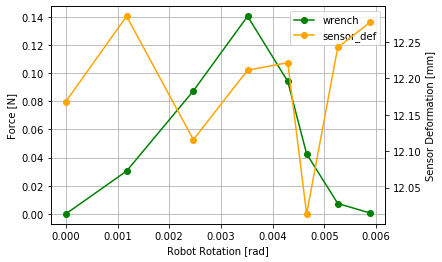

In [126]:
seq_fc = [i for i in range(2,9+1)]
reference_fc = 1
scene = 'bubbles'

wrenches = np.array([load_wrench(scene, fc_i, 'grasp_frame')[0,3] for fc_i in seq_fc])
# poses are the rotated angle along the grasp_frame x (med_base y)
poses = np.array([load_tf(scene, fc_i)[0,3:] for fc_i in seq_fc])
delta_quats = [tr.quaternion_multiply(q_i, tr.quaternion_inverse(poses[0])) for q_i in poses]
angles = [quaternion_to_axisangle(quat_i)[1] for quat_i in delta_quats]
# angles = [np.rad2deg(a_i) for a_i in angles]
poses = angles

poses = np.abs(poses - poses[0])
wrenches = np.abs(wrenches - wrenches[0])

left_defs = np.array(compute_deformations(seq_fc, reference_fc, scene, 'left'))
right_defs = np.array(compute_deformations(seq_fc, reference_fc, scene, 'left'))
fig,ax = plt.subplots()
ax.plot(poses, wrenches, label='wrench', color='g', marker='o')
ax.set_ylabel('Force [N]')
ax.set_xlabel('Robot Rotation [rad]')
ax_2 = ax.twinx()
ax_2.plot(poses, 0.5*(left_defs+right_defs)*1000, label='sensor_def', marker='o', color='orange')
# ax_2.plot(poses, right_defs*1000, label='right_def', marker='o')
ax_2.set_ylabel('Sensor Deformation [mm]')

lns = ax.get_lines() + ax_2.get_lines()
labs = [l.get_label() for l in lns]
ax.legend(lns, labs)
ax.grid()